In [17]:
matplotlib_style = 'fivethirtyeight'
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
import numpy as np
import tensorflow as tf
import os
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sksurv.linear_model.coxph import BreslowEstimator
matplotlib_style = 'fivethirtyeight'
import matplotlib.pyplot as plt; plt.style.use(matplotlib_style)
from sklearn.model_selection import train_test_split
from utility.training import get_data_loader, scale_data, make_time_event_split
from tools.model_builder import make_mcd_model
from utility.config import load_config
from utility.loss import CoxPHLoss
import paths as pt

# Load config
config = load_config(pt.MLP_CONFIGS_DIR, f"SEER.yaml")
optimizer = tf.keras.optimizers.deserialize(config['optimizer'])
custom_objects = {"CoxPHLoss": CoxPHLoss()}
with tf.keras.utils.custom_object_scope(custom_objects):
    loss_fn = tf.keras.losses.deserialize(config['loss_fn'])
activation_fn = config['activiation_fn']
layers = config['network_layers']
dropout_rate = config['dropout_rate']
l2_reg = config['l2_reg']
batch_size = config['batch_size']

# Load data
dl = get_data_loader("SEER").load_data()
X, y = dl.get_data()
num_features, cat_features = dl.get_features()

# Split data in train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=0)

# Scale data
X_train, X_test = scale_data(X_train, X_test, cat_features, num_features)
X_train = np.array(X_train)
X_test = np.array(X_test)

# Make time/event split
t_train, e_train = make_time_event_split(y_train)
t_test, e_test = make_time_event_split(y_test)

# Create model instance
model = make_mcd_model(input_shape=X_train.shape[1:], output_dim=2,
                       layers=layers, activation_fn=activation_fn,
                       dropout_rate=dropout_rate, regularization_pen=l2_reg)

# Restore the weights
curr_dir = os.getcwd()
root_dir = Path(curr_dir).absolute().parent
model.load_weights(f'{root_dir}/models/seer_mcd')

optimizer = tf.keras.optimizers.Adam()
loss_fn = CoxPHLoss()
model.compile(loss=loss_fn, optimizer=optimizer)

In [ ]:
model.summary()

In [18]:
# Make predictions
x_pred = X_test[:3]
for rep in range(5): #Predictions for 5 runs
    print(model.predict(x_pred, verbose=0)[0:3].T)

[[ 0.32760173 -0.19067551 -0.774713  ]]
[[0.7986048  0.8148     0.74693537]]
[[-0.2116866 -0.6306409 -0.7369641]]
[[-0.5679201  -0.21511966  0.02367288]]
[[-0.13952881 -0.9655116   1.157284  ]]


In [20]:
# Sample from the parameters for the post predictive
#from keras.models import Model
#layer_name = 'dense_flipout_23'
#model_params = Model(inputs=model.input,
#                     outputs=model.get_layer(layer_name).output)
#for rep in range(5): #Predictions for 5 runs
#    print(model_params.predict(x_pred, verbose=0)[0:3].T)

In [21]:
x_pred = X_test[:3]
runs = 100
vi_cpd = np.zeros((runs,len(x_pred)))
for i in range(0,runs):
    vi_cpd[i,:] = np.reshape(model.predict(x_pred, verbose=0), len(x_pred))

array([[-1.12424397, -0.04468948, -0.0323683 ],
       [-1.02875662,  0.61752641, -0.98881137],
       [-1.4420222 ,  1.56642103, -0.41082522],
       [-0.13537586, -0.12171282,  0.06164049],
       [ 0.51817   , -0.08780129,  0.98741275],
       [-1.00968158,  0.29157847,  1.51490211],
       [-0.32809991,  0.10337403,  0.72000694],
       [ 0.53756654, -0.0758608 ,  0.32649046],
       [ 1.52667654, -1.88871396,  0.60620129],
       [ 0.24684374,  0.54882699, -0.97953933],
       [-0.40789652, -0.46902746,  0.16388434],
       [ 0.15242305, -2.24918485, -1.29376614],
       [ 0.44985169, -0.03869691, -0.0044615 ],
       [ 0.0380649 ,  0.49374795,  0.06056358],
       [-0.33207315, -1.07384562,  0.50450736],
       [-0.48993617, -0.77210152, -0.45551881],
       [-0.15495962,  0.00604944,  0.47873032],
       [ 0.13708982, -0.38706613, -0.35445538],
       [-0.45082915,  0.3581576 ,  1.69372582],
       [-0.01212754, -0.59672666,  0.78403258],
       [ 0.93455458,  0.29457095, -0.568

In [22]:
# Train the Brewslow estimator
train_predictions = model.predict(X_train, verbose=0).reshape(-1)
breslow = BreslowEstimator().fit(train_predictions, e_train, t_train)

# Make model predictions
x_sample = X_test
runs = 100
model_vi = np.zeros((runs, len(x_sample)))
for i in range(0, runs):
    model_vi[i,:] = np.reshape(model.predict(x_sample, verbose=0), len(x_sample))
    
# Predict the surv func using Breslow to estimate variance
event_times = breslow.get_survival_function(model_vi[0])[0].x
breslow_surv_times = np.zeros((len(x_sample), runs, len(event_times)))
for i in range(0, runs):
    surv_fns = breslow.get_survival_function(model_vi[i,:])
    for j, surv_fn in enumerate(surv_fns):
        breslow_surv_times[j,i,:] = surv_fn.y

<Figure size 512x384 with 0 Axes>

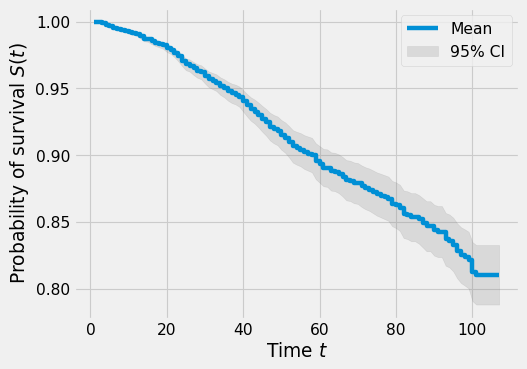

In [23]:
n_samples = breslow_surv_times.shape[1]

plt.figure(dpi=80)

obs_1_surv_times = breslow_surv_times[0,:,:]
ci_surv = 1.96 * np.std(obs_1_surv_times, axis=0) / np.sqrt(n_samples) # 95% CI
mean_surv_times = np.mean(obs_1_surv_times, axis=0)

# Plot surv funcs with mean and CI
plt.figure(dpi=80)
plt.step(event_times, mean_surv_times, where="post", label="Mean")
plt.fill_between(event_times, mean_surv_times-ci_surv, mean_surv_times+ci_surv,
                 color='gray', alpha=0.2, label="95% CI")
plt.ylabel("Probability of survival $S(t)$")
plt.xlabel("Time $t$")
plt.legend()
plt.grid(True)
plt.show()